# Δεδομένα Πειράματος και Διαλογή Εικόνων
## Ορισμός των μεταβλητών συστήματος 
1. Οι εικόνες βρίσκονται στο dir `/data/raw`
2. το notebook `01-data_access.ipynb` βρίσκεται στο `/notebooks`
3. οπότε για να έχουμε πρόσβαση πρέπει να μεταφερθούμε στο root project directory

### Δομή package 
- `src`
    - `data`
    - `features`
    - `models`
    - `visualization`
    
### Αρχικοποίηση Notebook
- καταχωρούμε αν δεν έχουμε ήδη στο σύστημα το directory του project
- δίνουμε πρόσβαση στο σύστημα για το πχ `C:\Users\plouk\Adiposer`
- Το σύστημα για την ώρα βρίσκεται στο `C:\Users\plouk\anaconda3\python.exe`

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from celluloid import Camera
from IPython.display import HTML # to show the animation in Jupyter
from tqdm import tqdm
from glob import glob
from skimage.exposure import histogram, cumulative_distribution
from skimage.filters.rank import entropy
from skimage.morphology import disk, square, skeletonize, thin, dilation
from skimage.util import img_as_ubyte
from skimage.feature import greycomatrix, greycoprops, local_binary_pattern
from sklearn import cluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from src.features import img_to_vectors
from src.features import mouse_detection
from src.data import data_utils
from sklearn import preprocessing

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)


### Φορτώνοντας τις θερμικές εικόνες έναρξης του πρώτου ποντικιού και κατασκευή θερμικών εικόνων

In [6]:
infrared_images = [] # stores (238, 98) arrays etc
exif_datum = []
items = glob(module_path + '/data/raw/0h/mouse_1/IR_*')
for item in items:
    infrared_image, exif_data = data_utils.IR_fixer(fpath=item)
    infrared_images.append(infrared_image)
    exif_datum.append(exif_data)
markerBack, markerBody = 70, 150

object_images, object_masks, initial_masks, mouse_locations = mouse_detection.mouse_detection(infrared_images, markerBack, markerBody)

csv_files = [] # stores (240, 160) arrays
items = glob(module_path + '/data/raw/0h/mouse_1/CSV_*')
for item in items:
    csv_files.append(data_utils.CSV_fixer(fpath=item))
# Χρήση Μορφολογικής Μάσκας για τις τιμές των θερμικών εικόνων
init_thermals = [initial_mask * csv_file  for (initial_mask, csv_file) in zip(initial_masks, csv_files)]
# Αποκοπή εικόνας στο Bounding Box
thermal_images = [init_thermal[mouse_location] for (init_thermal, mouse_location) in zip(init_thermals, mouse_locations)]

### Αφαίρεση του υποβάθρου τους και εμφάνιση

36it [00:02, 17.84it/s]


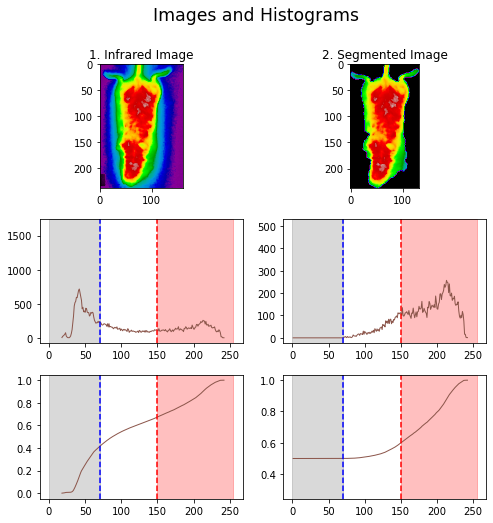

In [5]:
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.suptitle(t='Images and Histograms', fontsize='xx-large')
grid = fig.add_gridspec(nrows=3, ncols=2, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])
ax4 = fig.add_subplot(grid[2, 0])
ax5 = fig.add_subplot(grid[2, 1])
camera = Camera(fig)
for infrared_image, object_image in tqdm(zip(infrared_images, object_images)):
    ax0.imshow(X=infrared_image, cmap=plt.cm.nipy_spectral)
    ax0.set_title(label='1. Infrared Image')
    fig.add_subplot(ax0)
    
    ax1.imshow(X=object_image, cmap=plt.cm.nipy_spectral)
    ax1.set_title(label='2. Segmented Image')
    fig.add_subplot(ax1)
    
    #ax.set_title(label='1. Original Thermal Image')
    histCut, histCut_centers = histogram(img_as_ubyte(infrared_image))
    ax2.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax2.axvline(x=markerBody, color='red', linestyle='--')
    ax2.axvline(x=markerBack, color='blue', linestyle='--')
    ax2.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax2.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    fig.add_subplot(ax2)
    
    histCut, histCut_centers = histogram(img_as_ubyte(object_image))
    ax3.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax3.axvline(x=markerBody, color='red', linestyle='--')
    ax3.axvline(x=markerBack, color='blue', linestyle='--')
    ax3.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax3.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    fig.add_subplot(ax3)
    
    histCut, histCut_centers = cumulative_distribution(img_as_ubyte(infrared_image))
    ax4.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax4.axvline(x=markerBody, color='red', linestyle='--')
    ax4.axvline(x=markerBack, color='blue', linestyle='--')
    ax4.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax4.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    fig.add_subplot(ax4)
    
    histCut, histCut_centers = cumulative_distribution(img_as_ubyte(object_image))
    ax5.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax5.axvline(x=markerBody, color='red', linestyle='--')
    ax5.axvline(x=markerBack, color='blue', linestyle='--')
    ax5.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax5.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    fig.add_subplot(ax5)
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
HTML(animation.to_html5_video()) # displaying the animation

### Σύγκριση Ιστογραμμάτων Θερμικής Εικόνας και Ιστογράμματος Θερμοκρασιών

36it [00:00, 43.48it/s]


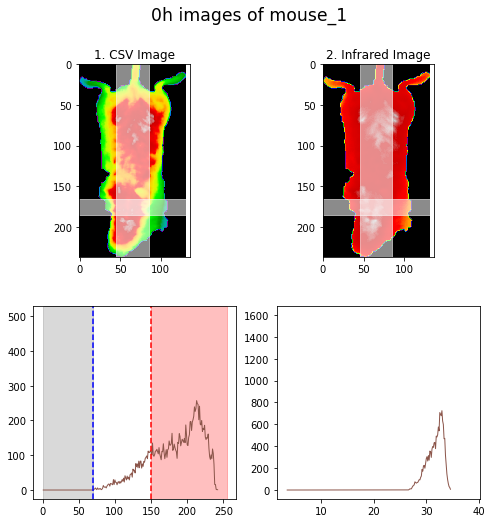

In [11]:
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.suptitle(t='0h images of mouse_1', fontsize='xx-large')
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0])
ax1 = fig.add_subplot(grid[1])
ax2 = fig.add_subplot(grid[2])
ax3 = fig.add_subplot(grid[3])
camera = Camera(fig)
for thermal_image, object_image in tqdm(zip(thermal_images, object_images)):
    ax0.imshow(X=object_image, cmap=plt.cm.nipy_spectral)
    xmin = int(0.35*thermal_image.shape[1])
    xmax = int(0.65*thermal_image.shape[1])
    ymin = int(0.70*thermal_image.shape[0])
    ymax = int(0.78*thermal_image.shape[0])
    ax0.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax0.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    ax0.set_title(label='1. CSV Image')
    fig.add_subplot(ax0)

    ax1.imshow(X=thermal_image, cmap=plt.cm.nipy_spectral)
    xmin = int(0.35*object_image.shape[1])
    xmax = int(0.65*object_image.shape[1])
    ymin = int(0.70*object_image.shape[0])
    ymax = int(0.78*object_image.shape[0])
    ax1.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax1.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)
    ax1.set_title(label='2. Infrared Image')
    fig.add_subplot(ax1)
    
    #ax.set_title(label='1. Original Thermal Image')
    histCut, histCut_centers = histogram(img_as_ubyte(object_image))
    ax2.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax2.axvline(x=markerBody, color='red', linestyle='--')
    ax2.axvline(x=markerBack, color='blue', linestyle='--')
    ax2.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax2.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    fig.add_subplot(ax2)
    
    histCut, histCut_centers = histogram(thermal_image)
    ax3.plot(histCut_centers[25:], histCut[25:], lw=1)
#     ax3.axvline(x=markerBody, color='red', linestyle='--')
#     ax3.axvline(x=markerBack, color='blue', linestyle='--')
#     ax3.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
#     ax3.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    fig.add_subplot(ax3)
    camera.snap()
animation = camera.animate(interval=500)
# το HTML πρέπει να τρέχει στο jupyter notebook 
HTML(animation.to_html5_video()) # displaying the animation

### Διόρθωση των εικόνων - Διόρθωση Φωτεινότητας (Luminance)

In [7]:
from skimage.exposure import adjust_gamma, adjust_log, adjust_sigmoid
gammas = [adjust_gamma(infrared_image) for infrared_image in infrared_images]
logs = [adjust_log(infrared_image) for infrared_image in infrared_images]
sigmos = [adjust_sigmoid(infrared_image) for infrared_image in infrared_images]

36it [00:02, 13.52it/s]


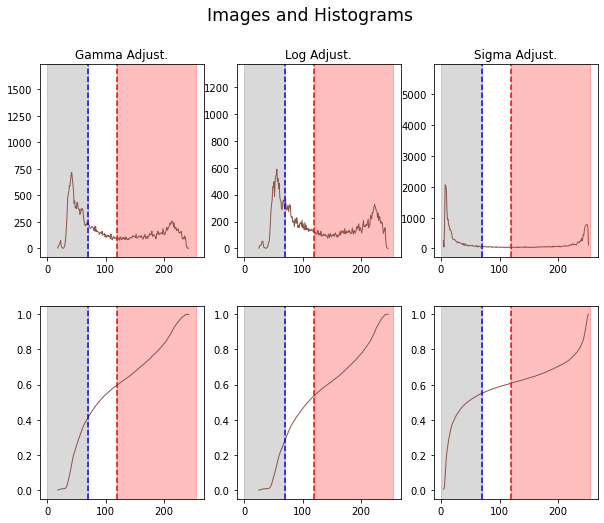

In [8]:
fig = plt.figure(figsize=(10, 8), constrained_layout=False)
fig.suptitle(t='Images and Histograms', fontsize='xx-large')
grid = fig.add_gridspec(nrows=2, ncols=3, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])
ax2 = fig.add_subplot(grid[0, 2])
ax3 = fig.add_subplot(grid[1, 0])
ax4 = fig.add_subplot(grid[1, 1])
ax5 = fig.add_subplot(grid[1, 2])
camera = Camera(fig)
for gamma, logg, sigmo in tqdm(zip(gammas, logs, sigmos)):
    
    histCut, histCut_centers = histogram(img_as_ubyte(gamma))
    ax0.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax0.axvline(x=markerBody, color='red', linestyle='--')
    ax0.axvline(x=markerBack, color='blue', linestyle='--')
    ax0.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax0.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    ax0.set_title(label='Gamma Adjust.')
    fig.add_subplot(ax0)
    
    #ax.set_title(label='1. Original Thermal Image')
    histCut, histCut_centers = histogram(img_as_ubyte(logg))
    ax1.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax1.axvline(x=markerBody, color='red', linestyle='--')
    ax1.axvline(x=markerBack, color='blue', linestyle='--')
    ax1.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax1.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    ax1.set_title(label='Log Adjust.')
    fig.add_subplot(ax1)
    
    histCut, histCut_centers = histogram(img_as_ubyte(sigmo))
    ax2.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax2.axvline(x=markerBody, color='red', linestyle='--')
    ax2.axvline(x=markerBack, color='blue', linestyle='--')
    ax2.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax2.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    ax2.set_title(label='Sigma Adjust.')
    fig.add_subplot(ax2)
    
    histCut, histCut_centers = cumulative_distribution(img_as_ubyte(gamma))
    ax3.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax3.axvline(x=markerBody, color='red', linestyle='--')
    ax3.axvline(x=markerBack, color='blue', linestyle='--')
    ax3.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax3.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    fig.add_subplot(ax3)
    
    histCut, histCut_centers = cumulative_distribution(img_as_ubyte(logg))
    ax4.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax4.axvline(x=markerBody, color='red', linestyle='--')
    ax4.axvline(x=markerBack, color='blue', linestyle='--')
    ax4.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax4.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    fig.add_subplot(ax4)
    
    histCut, histCut_centers = cumulative_distribution(img_as_ubyte(sigmo))
    ax5.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax5.axvline(x=markerBody, color='red', linestyle='--')
    ax5.axvline(x=markerBack, color='blue', linestyle='--')
    ax5.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax5.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    fig.add_subplot(ax5)
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
HTML(animation.to_html5_video()) # displaying the animation

### Διόρθωση των εικόνων - διόρθωση αντίθεσης (contrast)

In [9]:
from skimage.exposure import equalize_hist, equalize_adapthist
eq_hists = [equalize_hist(infrared_image) for infrared_image in infrared_images]
eq_adapts = [equalize_adapthist(infrared_image) for infrared_image in infrared_images]

36it [00:01, 19.32it/s]


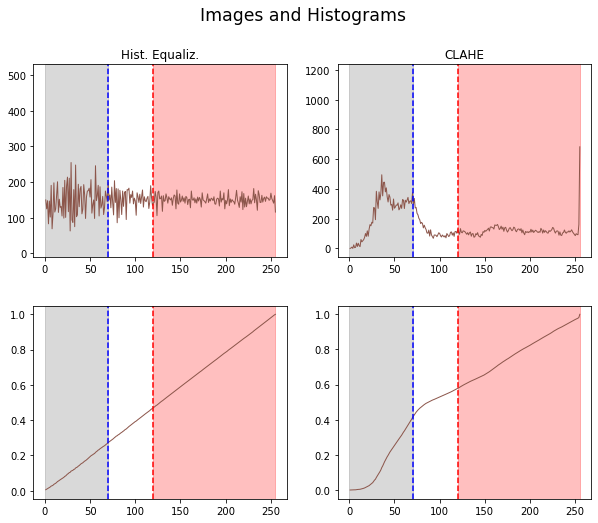

In [10]:
fig = plt.figure(figsize=(10, 8), constrained_layout=False)
fig.suptitle(t='Images and Histograms', fontsize='xx-large')
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])
camera = Camera(fig)
for eq_hist, eq_adapt in tqdm(zip(eq_hists, eq_adapts)):
    
    histCut, histCut_centers = histogram(img_as_ubyte(eq_hist))
    ax0.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax0.axvline(x=markerBody, color='red', linestyle='--')
    ax0.axvline(x=markerBack, color='blue', linestyle='--')
    ax0.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax0.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    ax0.set_title(label='Hist. Equaliz.')
    fig.add_subplot(ax0)
    
    #ax.set_title(label='1. Original Thermal Image')
    histCut, histCut_centers = histogram(img_as_ubyte(eq_adapt))
    ax1.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax1.axvline(x=markerBody, color='red', linestyle='--')
    ax1.axvline(x=markerBack, color='blue', linestyle='--')
    ax1.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax1.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    ax1.set_title(label='CLAHE')
    fig.add_subplot(ax1)
    
    histCut, histCut_centers = cumulative_distribution(img_as_ubyte(eq_hist))
    ax2.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax2.axvline(x=markerBody, color='red', linestyle='--')
    ax2.axvline(x=markerBack, color='blue', linestyle='--')
    ax2.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax2.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    fig.add_subplot(ax2)
    
    histCut, histCut_centers = cumulative_distribution(img_as_ubyte(eq_adapt))
    ax3.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax3.axvline(x=markerBody, color='red', linestyle='--')
    ax3.axvline(x=markerBack, color='blue', linestyle='--')
    ax3.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax3.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    fig.add_subplot(ax3)
    
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook
HTML(animation.to_html5_video()) # displaying the animation

36it [00:00, 214.28it/s]


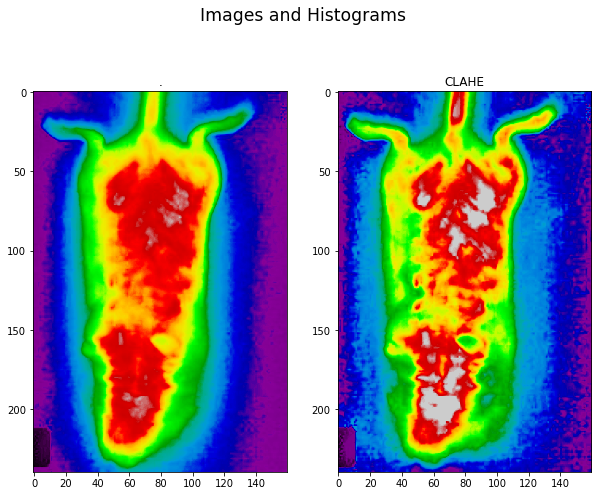

In [11]:
fig = plt.figure(figsize=(10, 8), constrained_layout=False)
fig.suptitle(t='Images and Histograms', fontsize='xx-large')
grid = fig.add_gridspec(nrows=1, ncols=2, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0])
ax1 = fig.add_subplot(grid[1])
camera = Camera(fig)
for infrared_image, eq_adapt in tqdm(zip(infrared_images, eq_adapts)):
    ax0.imshow(X=infrared_image, cmap=plt.cm.nipy_spectral)
    ax0.set_title(label='.')
    fig.add_subplot(ax0)
    
    #ax.set_title(label='1. Original Thermal Image')
    ax1.imshow(X=eq_adapt, cmap=plt.cm.nipy_spectral)
    ax1.set_title(label='CLAHE')
    fig.add_subplot(ax1)
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook
HTML(animation.to_html5_video()) # displaying the animation

36it [00:17,  2.07it/s]


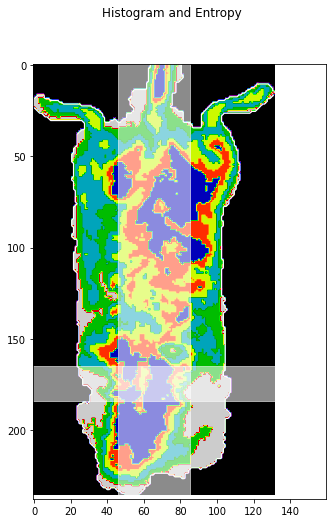

In [19]:
# infrared_images, eq_adapts
texture_images = []
radius = 10
n_points = 8 * radius + 4
for object_image in object_images:
    texture_image = local_binary_pattern(image=object_image, P=n_points, R=radius, method='uniform')
    texture_images.append(texture_image)
markerBack, markerBody = 90, 130
object_images, object_masks, initial_masks, mouse_locations = mouse_detection.mouse_detection(eq_adapts, markerBack, markerBody)
# texture_images = []
# for i, (initial_mask, object_mask, object_image) in tqdm(enumerate(zip(initial_masks, object_masks, object_images))):
#     # ordinatesX, ordinatesY = img_to_vectors.img_to_vectors(image)
#     # intensityFeature = image[ordinatesX, ordinatesY]
#     ordinatesX, ordinatesY = img_to_vectors.img_to_vectors(object_image)
#     intensityFeature = object_image[ordinatesX, ordinatesY]
    
#     radius = 10
#     n_points = 8 * radius + 4
#     texture_image = local_binary_pattern(image=object_image, P=n_points, R=radius, method='uniform')
#     texture_images.append(texture_image)

fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.suptitle(t='Histogram and Entropy')
grid = fig.add_gridspec(nrows=1, ncols=1, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(grid[0, 0])
n_clusters = 6
scores = []
roi_scores = []
roi_labeled_images = []
roi_images = []
camera = Camera(fig)
for i, (texture_image, object_mask, object_image) in tqdm(enumerate(zip(texture_images, object_masks, object_images))):
    ordinatesX, ordinatesY = img_to_vectors.img_to_vectors(object_image)
    n_samples = ordinatesX.size
    texture_feature = texture_image[ordinatesX, ordinatesY]
    intensity_feature = object_image[ordinatesX, ordinatesY]
    X = np.vstack((intensity_feature))
    # X = intensityFeature.reshape(-1, 1)
    # αν κανουμε clustering με το intensity ως feature
    # δηλαδή np.vstack((intensityFeature)) => (n_feature = 1)
    # τότε να κάνεις σχόλιο την παρακάτω γραμμή γιατί αλλιώς μπερδεύει τις διαστάσεις του Χ
    #X = X.transpose()
    #--------------- 2a Feature Scaling Methods ---------------------------------
    scaler = preprocessing.RobustScaler()
    X = scaler.fit_transform(X)
    # tweaking the hyperparameter
    lamdaHyperparameter = 20.0
    # X[:, 1] = np.sqrt(lamdaHyperparameter) * X[:, 1]
    kMeans = cluster.KMeans(n_clusters=n_clusters)
    kMeans.fit(X)
    CENTROIDS = kMeans.cluster_centers_.squeeze() # no random init at next iteration
    # print('Distance-based mouse centroids are ', CENTROIDS)
    labels = kMeans.labels_
    labeled_image = np.zeros_like(object_image, dtype='int')
    for i in range(n_samples):
        labeled_image[ordinatesX[i]][ordinatesY[i]] = labels[i] + 1
    xmin = int(0.35*object_image.shape[1])
    xmax = int(0.65*object_image.shape[1])
    ymin = int(0.70*object_image.shape[0])
    ymax = int(0.78*object_image.shape[0])
    ax0.axvspan(xmin=xmin, xmax=xmax, color='white', alpha=0.55)
    ax0.axhspan(ymin=ymin, ymax=ymax, color='white', alpha=0.55)    
    ax0.imshow(X=labeled_image, cmap=plt.cm.nipy_spectral)
    ax0.contour(object_mask, [0.5], linewidths=1.2, colors='w')
    fig.add_subplot(ax0)
    
#     roi_intensity_image = object_image[ymin:ymax, xmin:xmax]
#     roi_texture_image = texture_image[ymin:ymax, xmin:xmax]
#     roi_ordinatesX, roi_ordinatesY = img_to_vectors.img_to_vectors(roi_intensity_image)
    
#     roi_intensity_feature = roi_intensity_image[roi_ordinatesX, roi_ordinatesY]
#     roi_texture_feature = roi_texture_image[roi_ordinatesX, roi_ordinatesY]
#     X_roi = np.vstack((roi_texture_feature, roi_intensity_feature))
#     X_roi = X_roi.transpose()
#     roi_labeled_image = labeled_image[ymin:ymax, xmin:xmax]
#     roi_labeled_images.append(roi_labeled_image)
#     roi_labels = roi_labeled_image[roi_ordinatesX, roi_ordinatesY]
    
#     score = (silhouette_score(X, labels),
#          calinski_harabasz_score(X, labels),
#          davies_bouldin_score(X, labels))
#     scores.append(score)
#     roi_score = (silhouette_score(X_roi, roi_labels),
#          calinski_harabasz_score(X_roi, roi_labels),
#          davies_bouldin_score(X_roi, roi_labels))
#     roi_scores.append(roi_score)
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook 
HTML(animation.to_html5_video()) # displaying the animation

### Log, CLAHE

In [ ]:
logs = [adjust_log(infrared_image) for infrared_image in infrared_images]
eq_adapts = [equalize_adapthist(log) for log in logs]

In [ ]:
fig = plt.figure(figsize=(10, 8), constrained_layout=False)
fig.suptitle(t='Images and Histograms', fontsize='xx-large')
grid = fig.add_gridspec(nrows=2, ncols=2, wspace=0.2, hspace=0.25)
ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])
camera = Camera(fig)
for infrared_image, eq_adapt in tqdm(zip(infrared_images, eq_adapts)):
    
    histCut, histCut_centers = histogram(img_as_ubyte(infrared_image))
    ax0.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax0.axvline(x=markerBody, color='red', linestyle='--')
    ax0.axvline(x=markerBack, color='blue', linestyle='--')
    ax0.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax0.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    ax0.set_title(label='Original.')
    fig.add_subplot(ax0)
    
    #ax.set_title(label='1. Original Thermal Image')
    histCut, histCut_centers = histogram(img_as_ubyte(eq_adapt))
    ax1.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax1.axvline(x=markerBody, color='red', linestyle='--')
    ax1.axvline(x=markerBack, color='blue', linestyle='--')
    ax1.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax1.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    ax1.set_title(label='Log, CLAHE')
    fig.add_subplot(ax1)
    
    histCut, histCut_centers = cumulative_distribution(img_as_ubyte(infrared_image))
    ax2.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax2.axvline(x=markerBody, color='red', linestyle='--')
    ax2.axvline(x=markerBack, color='blue', linestyle='--')
    ax2.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax2.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    fig.add_subplot(ax2)
    
    histCut, histCut_centers = cumulative_distribution(img_as_ubyte(eq_adapt))
    ax3.plot(histCut_centers[1:], histCut[1:], lw=1)
    ax3.axvline(x=markerBody, color='red', linestyle='--')
    ax3.axvline(x=markerBack, color='blue', linestyle='--')
    ax3.axvspan(xmin=markerBody, xmax=255, color='red', alpha=0.25)
    ax3.axvspan(xmin=0, xmax=markerBack, color='black', alpha=0.15)
    fig.add_subplot(ax3)
    
    camera.snap()
animation = camera.animate(interval=1000)
# το HTML πρέπει να τρέχει στο jupyter notebook
HTML(animation.to_html5_video()) # displaying the animation